# ResNet

In [1]:
from tensorflow import keras
from tensorflow.keras import layers, models

import numpy as np

from d2l.tensorflow import config, data, plot

config.setup('GPU')

Tensorflow running on GPU


## Residual Layer

In [2]:
class ResidualLayer(layers.Layer):
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(ResidualLayer, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(num_channels, kernel_size=3, padding='same', strides=strides)
        self.conv2 = layers.Conv2D(num_channels, kernel_size=3, padding='same')
        if use_1x1conv:
            self.conv3 = layers.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.relu = keras.activations.relu

    def call(self, inputs):
        Y = self.relu(self.bn1(self.conv1(inputs)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            inputs = self.conv3(inputs)
        return self.relu(Y + inputs)

In [3]:
blk = ResidualLayer(3)
X = np.random.uniform(size=(4, 6, 6, 3)).astype(np.float32)
blk(X).shape

TensorShape([4, 6, 6, 3])

In [4]:
blk = ResidualLayer(3, use_1x1conv=True, strides=2)
X = np.random.uniform(size=(4, 6, 6, 3)).astype(np.float32)
blk(X).shape

TensorShape([4, 3, 3, 3])

## Resnet Block

In [5]:
class ResnetBlock(layers.Layer):
    def __init__(self, num_channels, num_residuals, first_block=False, **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.residual_layers.append(ResidualLayer(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(ResidualLayer(num_channels))

    def call(self, inputs):
        for layer in self.residual_layers:
            inputs = layer(inputs)
        return inputs

### Resnet Stage 1

In [6]:
stage1 = models.Sequential()
stage1._name = 'stage_1'

stage1.add(layers.ZeroPadding2D(3))
stage1.add(layers.Conv2D(64, kernel_size=7, strides=2))
stage1.add(layers.BatchNormalization())
stage1.add(layers.Activation('relu'))
stage1.add(layers.ZeroPadding2D(1))
stage1.add(layers.MaxPool2D(pool_size=3, strides=2))

### Resnet blocks in the network

In [7]:
resnet = models.Sequential()

resnet.add(stage1)

resnet.add(ResnetBlock(64, 2, first_block=True))
resnet.add(ResnetBlock(128, 2))
resnet.add(ResnetBlock(256, 2))
resnet.add(ResnetBlock(512, 2))

resnet.add(layers.GlobalAveragePooling2D())
resnet.add(layers.Dense(10, activation='softmax'))

resnet.build((None, 224, 224, 1))

In [8]:
X = np.random.uniform(size=(1, 224, 224, 1)).astype(np.float32)

for layer in resnet.layers:
    X = layer(X)
    print('{} output shape: {}'.format(layer.name, X.shape))

stage_1 output shape: (1, 56, 56, 64)
resnet_block output shape: (1, 56, 56, 64)
resnet_block_1 output shape: (1, 28, 28, 128)
resnet_block_2 output shape: (1, 14, 14, 256)
resnet_block_3 output shape: (1, 7, 7, 512)
global_average_pooling2d output shape: (1, 512)
dense output shape: (1, 10)


In [9]:
resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stage_1 (Sequential)         multiple                  3456      
_________________________________________________________________
resnet_block (ResnetBlock)   multiple                  148736    
_________________________________________________________________
resnet_block_1 (ResnetBlock) multiple                  526976    
_________________________________________________________________
resnet_block_2 (ResnetBlock) multiple                  2102528   
_________________________________________________________________
resnet_block_3 (ResnetBlock) multiple                  8399360   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                 

## Training

In [10]:
batch_size = 128
epochs = 5
learning_rate = 0.1

optmizer = keras.optimizers.SGD(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()
metric = keras.metrics.CategoricalAccuracy()

resnet.compile(optimizer=optmizer, loss=loss, metrics=metric)

In [11]:
X_train, y_train, X_test, y_test = data.load_fashion_mnist_keras()

resize = [224, 224]
train_iter = data.resize_images_generator(X_train, y_train, batch_size, resize)
test_iter = data.resize_images_generator(X_test, y_test, batch_size, resize)

train_steps = len(X_train) // batch_size + 1
val_steps = len(X_test) // batch_size + 1

In [12]:
hist = resnet.fit(train_iter, epochs=epochs, validation_data=test_iter, steps_per_epoch=train_steps, validation_steps=val_steps)

Epoch 1/5
469/469 [==============================] - 372s 794ms/step - loss: 0.5431 - categorical_accuracy: 0.8197 - val_loss: 0.3438 - val_categorical_accuracy: 0.8759
Epoch 2/5
469/469 [==============================] - 371s 790ms/step - loss: 0.2540 - categorical_accuracy: 0.9067 - val_loss: 0.2645 - val_categorical_accuracy: 0.9033
Epoch 3/5
469/469 [==============================] - 366s 781ms/step - loss: 0.1923 - categorical_accuracy: 0.9305 - val_loss: 0.2647 - val_categorical_accuracy: 0.9061
Epoch 4/5
469/469 [==============================] - 367s 782ms/step - loss: 0.1437 - categorical_accuracy: 0.9491 - val_loss: 0.2757 - val_categorical_accuracy: 0.9085
Epoch 5/5
469/469 [==============================] - 370s 788ms/step - loss: 0.1012 - categorical_accuracy: 0.9655 - val_loss: 0.3250 - val_categorical_accuracy: 0.8998


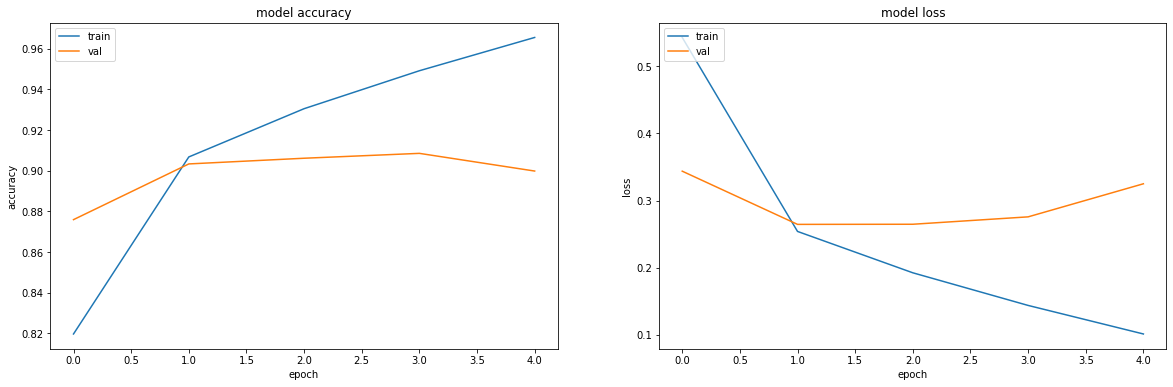

In [16]:
plot.plot_history(hist, 'categorical_accuracy')